# Topic Extraction in RSS-Feed Corpus

- Author:      Johannes Maucher
- Last update: 2018-11-16

In the [notebook 01gensimDocModelSimple](01gensimDocModelSimple.ipynb) the concepts of dictionaries, document models, tf-idf and similarity have been described using an example of a samll document collection. Moreover, in [notebook 02LatentSemanticIndexing](02LatentSemanticIndexing.ipynb) LSI based topic extraction and document clustering have also been introduced by a small playground example.

The current notebook applies these concepts to a real corpus of RSS-Feeds, which has been generated and accessed in previous notebooks of this lecture:

## Read documents from a corpus 

The contents of the RSS-Fedd corpus are imported by NLTK's `CategorizedPlaintextCorpusReader` as already done in previous notebooks of this lecture:

In [1]:
#!pip install wordcloud

In [2]:
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.corpus import stopwords
stopwordlist=stopwords.words('german')
from wordcloud import WordCloud

rootDir="../01access/GERMAN"
filepattern=r"(?!\.)[\w_]+(/RSS/FeedText/)[\w-]+/[\w-]+\.txt"
#filepattern=r"(?!\.)[\w_]+(/RSS/FullText/)[\w-]+/[\w-]+\.txt"
catpattern=r"([\w_]+)/.*"
rssreader=CategorizedPlaintextCorpusReader(rootDir,filepattern,cat_pattern=catpattern)

In [3]:
singleDoc=rssreader.paras(categories="TECH")[0]
print("The first paragraph:\n",singleDoc)
print("Number of paragraphs in the corpus: ",len(rssreader.paras(categories="TECH")))

The first paragraph:
 [['Zur', 'kalten', 'Jahreszeit', 'nur', '1', '%', 'Akku', '?'], ['Dieser', 'Befehl', 'hält', 'den', 'iPhone', '-', 'Akku', 'länger', 'am', 'Leben', 'Im', 'Auto', ',', 'bei', 'einem', 'wichtigen', 'Anruf', 'oder', 'wenn', 'man', 'abends', 'unterwegs', 'ist', ':', 'Der', 'Akku', 'des', 'Smartphones', 'geht', 'immer', 'dann', 'leer', ',', 'wenn', 'man', 'ihn', 'am', 'dringendsten', 'braucht', '.'], ['Wir', 'zeigen', 'Ihnen', 'einen', 'praktischen', 'Trick', ',', 'mit', 'dem', 'Sie', 'die', 'Laufzeit', 'Ihres', 'iPhones', 'auch', 'bei', 'niedrigem', 'Batteriestand', 'verlängern', 'können', '.']]
Number of paragraphs in the corpus:  160


In [4]:
techdocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="TECH")]
print("Number of documents in category Tech: ",len(techdocs))

Number of documents in category Tech:  160


In [5]:
generaldocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="GENERAL")]
print("Number of documents in category General: ",len(generaldocs))

Number of documents in category General:  334


In [6]:
alldocs=techdocs+generaldocs
print("Total number of documents: ",len(alldocs))

Total number of documents:  494


### Remove duplicate news

In [7]:
def removeDuplicates(nestedlist):
    listOfTuples=[tuple(liste) for liste in nestedlist]
    uniqueListOfTuples=list(set(listOfTuples))
    return [list(menge) for menge in uniqueListOfTuples]

In [8]:
techdocs=removeDuplicates(techdocs)
generaldocs=removeDuplicates(generaldocs)
alldocs=removeDuplicates(alldocs)
print("Number of unique documents in category Tech: ",len(techdocs))
print("Number of unique documents in category General: ",len(generaldocs))
print("Total number of unique documents: ",len(alldocs))

Number of unique documents in category Tech:  160
Number of unique documents in category General:  285
Total number of unique documents:  445


In [9]:
alltechString=" ".join([w for doc in techdocs for w in doc])
print(len(alltechString))
allgeneralString=" ".join([w for doc in generaldocs for w in doc])
print(len(allgeneralString))

30680
53511


(-0.5, 399.5, 199.5, -0.5)

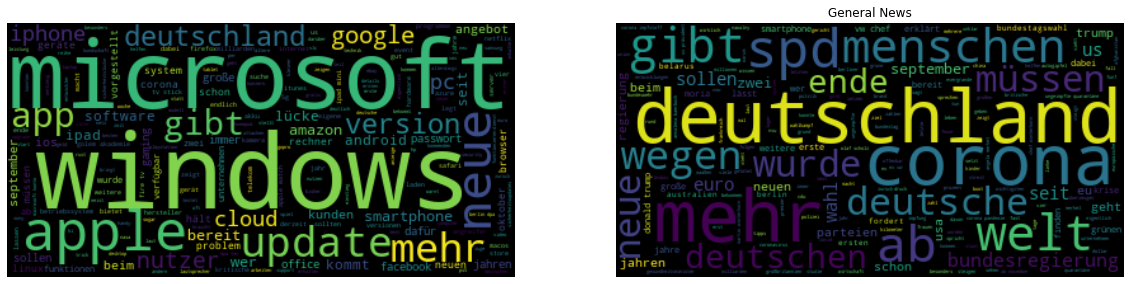

In [10]:
wordcloudTech=WordCloud().generate(alltechString)
wordcloudGeneral=WordCloud().generate(allgeneralString)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,18))
plt.title("Tech News")
plt.subplot(1,2,1)
plt.imshow(wordcloudTech, interpolation='bilinear')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(wordcloudGeneral, interpolation='bilinear')
plt.title("General News")
plt.axis("off")

## Gensim-representation of imported RSS-feeds 

In [11]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(alldocs)
dictionary.save('feedwordsDE.dict') # store the dictionary, for future reference
#print(dictionary.token2id)
print(len(dictionary))

4845


In [12]:
firstdoc=techdocs[0]
print(firstdoc)
firstVec = dictionary.doc2bow(firstdoc)
print("Sparse BoW representation of single document: %s"%firstVec)
w1='windows'
w2='apple'
w3='system'
print("Index of word %s is %d"%(w1,dictionary.token2id[w1]))
print("Index of word %s is %d"%(w2,dictionary.token2id[w2]))
print("Index of word %s is %d"%(w3,dictionary.token2id[w3]))

['schulpolitik', 'streit', 'vergabe', 'videosystem', 'legt', 'hessen', 'beschwerde', 'hunderte', 'schulen', 'müssten', 'mittlerweile', 'eigentlich', 'datenschutzgründen', 'videokonferenzsystem', 'nutzen', 'nachprüfungsantrag', 'unterbindet']
Sparse BoW representation of single document: [(333, 1), (369, 1), (1093, 1), (1144, 1), (1657, 1), (1658, 1), (1659, 1), (1660, 1), (1661, 1), (1662, 1), (1663, 1), (1664, 1), (1665, 1), (1666, 1), (1667, 1), (1668, 1), (1669, 1)]
Index of word windows is 559
Index of word apple is 358
Index of word system is 540


Sparse BoW representation of entire tech-corpus and entire general-news-corpus: 

In [13]:
techcorpus = [dictionary.doc2bow(doc) for doc in techdocs]
generalcorpus = [dictionary.doc2bow(doc) for doc in generaldocs]

In [14]:
print(generaldocs[:3])

[['bundestagswahl', 'letzte', 'kabinettssitzung', 'großen', 'koalition', 'wahl', 'große', 'koalition', 'union', 'spd', 'regiert', 'seit', '2005', 'merkel', 'spd', 'kanzlerkandidat', 'olaf', 'scholz', 'neuauflage', 'wahl', 'ausgesprochen'], ['überraschende', 'widerstand', 'weißrussischen', 'jugend', 'weißrussland', 'manifestiert', 'widerstand', 'lukaschenko', 'regime', 'straße', 'netz', 'mithilfe', 'unterstützer', 'exil', 'ausgerechnet', 'traditionelle', 'handwerkskunst', 'symbol', 'neuen', 'bewegung'], ['dringend', 'gesucht', 'top', 'bezahlt', 'gelingt', 'einstieg', 'job', 'zukunft', 'künstliche', 'intelligenz', 'ki', 'gilt', 'zukunftstechnologie', 'schlechthin', 'kaum', 'verwunderlich', 'experten', 'maschinelles', 'lernen', 'co', 'begehrt', 'studierte', 'informatiker', 'davon', 'profitieren', 'schlagen', 'richtung', 'ki', 'programmierer', 'karriere']]


## Find similiar documents

In [15]:
index = similarities.SparseMatrixSimilarity(techcorpus, num_features=len(dictionary))

In [16]:
sims = index[firstVec]
#print(list(enumerate(sims)))
simlist = sims.argsort()
print(simlist)
mostSimIdx=simlist[-2]

[ 79  95  96  97  98  99 100  94 102 104 105 106 107 108 109 103  93  92
  91  76 157  78 158 156  81  82  83  84  85  86  87  88  89  90 155 112
 113 114 134 135 136 137 138 139 140 141 142 143 144 153 152 147 148 133
 149 132 130 154 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 131  74  75  72  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  19  35  18  16   1   2   3   4   5   6   7   8   9  10  11  12  13
  14  15  17  36  37  38  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  56  55  54  53  39  40  41  42  43  44  73  45  47  48  49
  50  51  52  46 151 101 110 159 150  77  80 115 146 145 111   0]


In [17]:
print("Refernce document is:\n",firstdoc)
print("Most similar document:\n",techdocs[mostSimIdx])

Refernce document is:
 ['schulpolitik', 'streit', 'vergabe', 'videosystem', 'legt', 'hessen', 'beschwerde', 'hunderte', 'schulen', 'müssten', 'mittlerweile', 'eigentlich', 'datenschutzgründen', 'videokonferenzsystem', 'nutzen', 'nachprüfungsantrag', 'unterbindet']
Most similar document:
 ['streit', 'vorratsdatenspeicherung', 'deutschland', 'beschäftigt', 'eugh', 'auftrag', 'bundesverwaltungsgerichts', 'frage', 'beantwortet', 'deutsche', 'regelung', 'europäischen', 'grundrechten', 'vereinbar']


## Find topics by Latent Semantic Indexing (LSI)
### Generate tf-idf model of corpus

In [18]:
tfidf = models.TfidfModel(techcorpus)
corpus_tfidf = tfidf[techcorpus]
print("Display TF-IDF- Model of first 2 documents of the corpus")
for doc in corpus_tfidf[:2]:
    print(doc)

Display TF-IDF- Model of first 2 documents of the corpus
[(333, 0.22034972946019057), (369, 0.19996096090040522), (1093, 0.2552045595298952), (1144, 0.18549489939048597), (1657, 0.2552045595298952), (1658, 0.2552045595298952), (1659, 0.2552045595298952), (1660, 0.17427415034852317), (1661, 0.2552045595298952), (1662, 0.2552045595298952), (1663, 0.2552045595298952), (1664, 0.2552045595298952), (1665, 0.2552045595298952), (1666, 0.2552045595298952), (1667, 0.2552045595298952), (1668, 0.2552045595298952), (1669, 0.2552045595298952)]
[(438, 0.18017054767673055), (550, 0.12562079707080132), (757, 0.22994661084371104), (3383, 0.22994661084371104), (4016, 0.22994661084371104), (4017, 0.22994661084371104), (4018, 0.4598932216874221), (4019, 0.22994661084371104), (4020, 0.22994661084371104), (4021, 0.22994661084371104), (4022, 0.22994661084371104), (4023, 0.4598932216874221), (4024, 0.22994661084371104), (4025, 0.22994661084371104)]


### Generate LSI model from tf-idf model

In [19]:
techdictionary = corpora.Dictionary(techdocs)

In [20]:
NumTopics=20
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=NumTopics) # initialize an LSI transformation

In [21]:
corpus_lsi = lsi[corpus_tfidf]

Display first 10 topics:

In [22]:
lsi.print_topics(10)

[(0,
  '-0.413*"windows" + -0.403*"microsoft" + -0.360*"11" + -0.133*"apple" + -0.117*"oktober" + -0.116*"neue" + -0.113*"office" + -0.106*"nutzer" + -0.102*"betriebssystem" + -0.101*"10"'),
 (1,
  '-0.507*"apple" + -0.274*"ipad" + 0.207*"microsoft" + -0.205*"15" + -0.182*"mini" + -0.158*"watch" + -0.152*"ios" + -0.132*"homepod" + 0.126*"11" + -0.113*"tvos"'),
 (2,
  '-0.340*"azure" + -0.273*"linux" + 0.239*"11" + -0.237*"cloud" + 0.235*"windows" + -0.183*"kritische" + -0.183*"lücke" + -0.176*"omigod" + -0.153*"updates" + -0.138*"kunden"'),
 (3,
  '-0.287*"google" + -0.242*"android" + -0.219*"12" + 0.157*"ipad" + 0.151*"microsoft" + -0.146*"version" + -0.144*"deutschland" + -0.140*"firefox" + -0.130*"itunes" + 0.128*"11"'),
 (4,
  '-0.429*"ipad" + -0.225*"mini" + -0.203*"test" + 0.193*"apple" + -0.186*"apples" + -0.186*"praxis" + 0.147*"watch" + -0.142*"10" + -0.122*"leistung" + -0.121*"deal"'),
 (5,
  '-0.271*"12" + -0.214*"itunes" + -0.177*"android" + -0.175*"google" + 0.156*"update"

### Determine the most relevant documents for a selected topic

Generate a numpy array `docTopic`. The entry in row $i$, column $j$ of this array is the relevance value for topic $j$ in document $i$.

In [23]:
import numpy as np
numdocs= len(corpus_lsi)
docTopic=np.zeros((numdocs,NumTopics))

In [24]:
for d,doc in enumerate(corpus_lsi): # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
    for t,top in enumerate(doc):
        docTopic[d,t]=top[1]
print(docTopic.shape)
print(docTopic)

(160, 20)
[[-0.01601314  0.00043367 -0.01850127 ... -0.03604195  0.04664228
  -0.04807997]
 [-0.01418209 -0.00855403  0.0158023  ... -0.07839297 -0.00595828
  -0.02214802]
 [-0.07206527 -0.05306242 -0.09280727 ...  0.07436582  0.17753052
   0.09300895]
 ...
 [-0.05105664 -0.05943693  0.01586927 ... -0.13302399 -0.04646873
  -0.01751157]
 [-0.02281646 -0.00543213 -0.00600662 ...  0.04892376  0.00340494
  -0.05044813]
 [-0.0567156  -0.06263666 -0.02474362 ...  0.03072947  0.07322557
  -0.05716186]]


Select an arbitrary topic-id and determine the documents, which have the highest relevance value for this topic:

In [25]:
topicId=7 #select an arbitrary topic-id
topicRelevance=docTopic[:,topicId]

In [26]:
docsoftopic= np.array(topicRelevance).argsort()
relevanceValue= np.sort(topicRelevance)
print(docsoftopic) #most relevant document for selected topic is at first position
print(relevanceValue) #highest relevance document/topic-relevance-value is at first position

[ 48 117  43 102  67  34  69 133   4 105  40   6 157 149  59 132 114 104
  18  57  73  19 134 154 136 135  87  35  78  92  94  44  72  45  63   5
  33  12  93  74  13  58  22 140  10  70  66  53 137  83   7   2  26  38
 146 151  28 112  37  25  95 108  20 152 100 125 158 138  97  27  88  51
 156 115 144 150  77  31 101  17  29 107 122  71  56 111  99  42 110 131
 124 130  39  68  36 143  61  81  60  98  52   0 145 139   8  76  47  14
 126  86 116 109  15 155  65  54   1  89  16 113 121 127 120  49 148 147
  64  62  46  79  84  80  85  21 106  11   9 129  55  82  91 128 141 153
  32   3  75  41  23 142  24 123 159 119  30 118  90 103  50  96]
[-2.22125238e-01 -1.95809425e-01 -1.80049873e-01 -1.75470147e-01
 -1.71119000e-01 -1.69084867e-01 -1.58720364e-01 -1.46927005e-01
 -1.46719723e-01 -1.27736665e-01 -1.25388849e-01 -1.19585393e-01
 -1.17316730e-01 -1.15885713e-01 -1.12170396e-01 -1.10192503e-01
 -1.08844647e-01 -1.08603707e-01 -9.59402818e-02 -9.06253308e-02
 -8.93154212e-02 -8.44946

In [27]:
TOP=8
print("Selected Topic:\n",lsi.show_topic(topicId))
print("#"*50)
print("Docs with the highest negative value w.r.t the selected topic")
for idx in docsoftopic[:TOP]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])
print("#"*50)
print("Docs with the highest positive value w.r.t the selected topic")
for idx in docsoftopic[-TOP:]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])

Selected Topic:
 [('macos', 0.30451991182661536), ('safari', 0.30063707105320264), ('firefox', 0.2666276975158559), ('browser', 0.2240689447621653), ('mozilla', 0.13336448420654887), ('15', 0.13031886312819832), ('amazon', -0.1272950183000966), ('design', 0.12629182371568973), ('sur', 0.12123835236922399), ('catalina', 0.12123835236922399)]
##################################################
Docs with the highest negative value w.r.t the selected topic
--------------------
48 
 ['asus', 'gaming', 'monitor', 'deal', 'amazon', 'ebay', 'leistungsstarken', 'gaming', 'pc', 'start', 'passende', 'monitor', 'fehlt', 'amazon', 'ebay', 'bekommen', 'tolles', 'modell', 'asus', 'vorzugspreis']
--------------------
117 
 ['iphone', '13', '13', 'pro', 'bessere', 'bildschirme', 'kameras', 'größerer', 'akku', 'apple', 'stellt', 'leistungs', 'detailverbesserungen', 'neuen', 'iphones', 'mittelpunkt', 'größerer', 'akku', 'manko', 'iphone', '12', 'ausräumen']
--------------------
43 
 ['ab', '19', 'uhr', 'i

In [28]:
import gensim


In [29]:
lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=20, id2word = dictionary)

In [30]:
#!pip install pyLDAvis

In [31]:
#import pyLDAvis.gensim as gensimvis
#import pyLDAvis

#vis_en = gensimvis.prepare(lda, corpus_tfidf, dictionary)
#pyLDAvis.display(vis_en)